# Feedback Generator 

- Draft: Feb 28, 2025
- Brian Locke MD MSCI

In [1]:
# Needed packages
import pandas as pd
import numpy as np
import openai
import os
from dotenv import load_dotenv
import json

load_dotenv()  # looks for a .env file in the current dir by default- should contain a line "OPENAI_API_KEY=yourkey"
#print(os.getenv("OPENAI_API_KEY"))

True

### Framing

Learners can make two types of errors:
	1.	Failing to gather key information.
	2.	Misinterpreting the meaning of collected data.

In practice, these processes—information gathering and reasoning—are interconnected, as reasoning guides the questions asked during an encounter. However, separating them in feedback can help learners pinpoint areas for improvement. For now, feedback is only provided at the end, so we are limited to evaluating both processes based on the completed interview.


## Information Gathering


Inputs: Correct diagnosis, learner’s differential, and transcript.

Outputs: A list of key evidence that differentiates cases where the learner’s differential diagnosis was correct vs. the actual correct diagnosis.

Challenges:
- Learners may list many possible diagnoses, requiring feedback across a broad range.
- Usefulness is measured by differential LR (A vs. B) rather than the usual (overall) LR (A vs. not A).

![Type 1. The first is the 'overall' likelihood ratio, which is the frequency.png](<attachment:Type 1. The first is the 'overall' likelihood ratio, which is the frequency.png>)
(from https://academic.oup.com/book/31795/chapter/266181309?login=false)

Approach:
- Collected all DDx from Cory's list; in production, this can be auto-extracted from the transcript.
- Used GPT-4o to identify key discriminating factors in:
	- HPI, Context (Medical, Surgical, Medications, Social, Family), Vitals/Exam, and Testing.
- In production, we’d automate detecting whether the learner asked about these factors and generate feedback:
	- “X was important, and you asked it.”
	- “Y was important, but you didn’t ask it.”
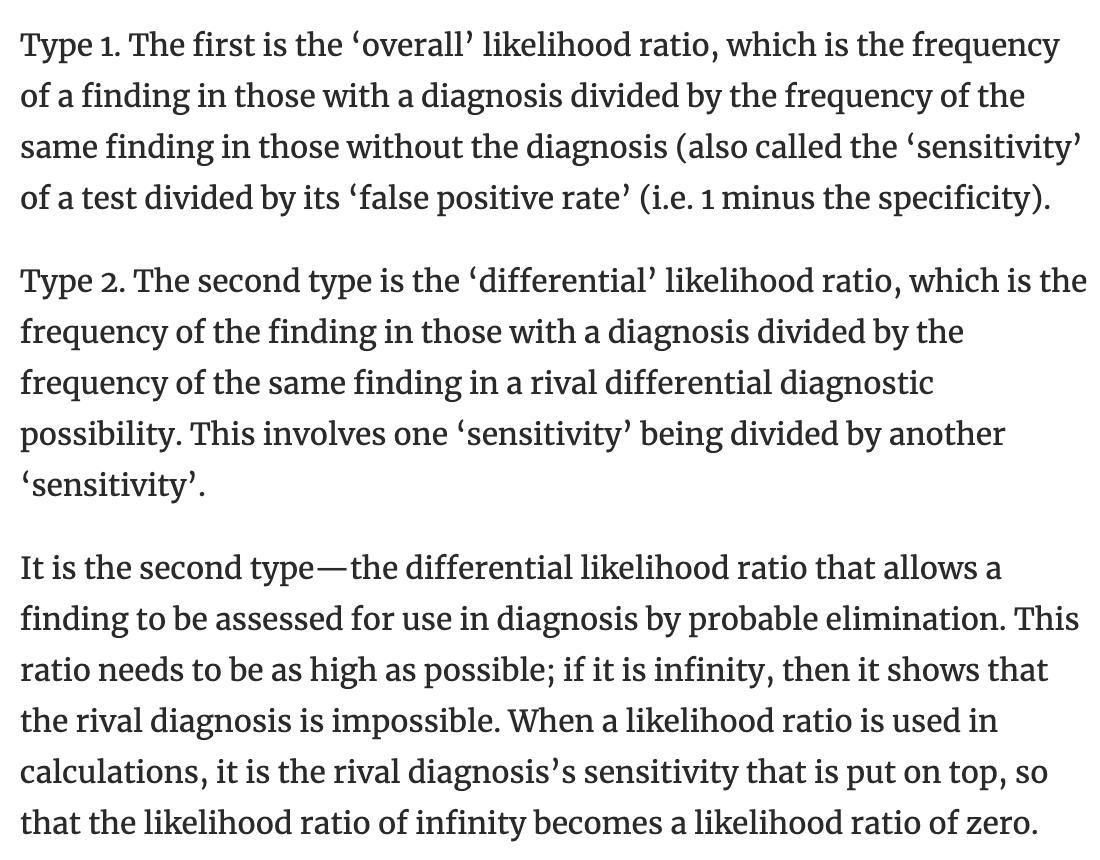

In [2]:
# Input Specification
# TODO: for production, extract these automatically from transcripts/directory

correct_diagnosis = "CREST syndrome"

differential_diagnoses = [
    "Scleroderma",
    "Esophageal stricture",
    "Food impaction",
    "MCTD",
    "Achalasia (type 1)",
    "Eosinophilic esophagitis",
    "Cardiac: ACS",
    "Stable Angina",
    "Esophageal spasm (DES) or Jackhammer Esophagus",
    "Esophageal adenocarcinoma",
    "Esophageal squamous cell carcinoma",
    "Musculoskeletal chest pain",
    "GERD",
    "Zenker's diverticulum",
    "Polymyositis",
    "Dermatomyositis",
    "Chagas Disease",
    "Anxiety",
    "Arrhythmia",
    "Aortic dissection",
    "Pericarditis",
    "Extrinsic compressing mass on esophagus",
    "RA",
    "Sarcoidosis",
    "Pill esophagitis",
    "Myasthenia gravis",
    "Gastroparesis"
]

categories_of_info = [
    "History of Present Illness (the description from the onset of symptoms up to and including the patient's present experience)", 
    "Medical and Surgical History, including Medications", 
    "Social History, Health Behaviors, and Family History", 
    "Vitals and Physical Exam", 
    "Test Results (labs, imaging, procedures, etc.)"
    ]

In [3]:
# Function to generate structured prompt
def generate_prompt(correct_diagnosis, differential_diagnosis, category_of_info):
    return f"""
    You are a knowledgeable medical reasoning AI, trained to identify and compare the most discriminative clinical findings between two specific diagnoses. However, you must limit your consideration to a single category of information: {category_of_info}.

    Your responses must be:
    - Accurate and maximally valid for research-level work.
    - Relevant to each diagnosis's typical presentation, focusing on the **differential** likelihood ratio ({correct_diagnosis} vs. {differential_diagnosis}) rather than overall likelihood ratios.
    - Strictly formatted in **JSON** to facilitate downstream parsing.
    - Explicit about any abbreviations, defining them if used.
    - Concise about uncertainties (e.g., if data is limited).

    ### Context and Focus:
    - Only consider clinical information from the specified category: {category_of_info}.
    - The measure of interest is the **differential likelihood ratio**—how a finding discriminates {correct_diagnosis} from {differential_diagnosis}, or vice versa.
    - Do **not** feel compelled to provide numeric likelihood ratios; instead, focus on **which pieces of information** in {category_of_info} would best discriminate one diagnosis from the other.

    ### Task:
    1. List the **top 5 pieces of information** (within {category_of_info}) that, if discovered, would most strongly **support {correct_diagnosis}** over {differential_diagnosis}.
    2. List the **top 5 pieces of information** (within {category_of_info}) that, if discovered, would most strongly **support {differential_diagnosis}** over {correct_diagnosis}.

    ### Output Format (Strict JSON):
    {{
      "diagnosisA_strongest_evidence": [
        {{
          "finding": "A finding relevant to {correct_diagnosis} from {category_of_info}",
          "explanation": "Why this finding favors {correct_diagnosis} over {differential_diagnosis}",
          "abbreviation_expansion": {{
            "abbreviation": "Expanded term if an abbreviation is used"
          }}
        }},
        "... (total of 5 items) ..."
      ],
      "diagnosisB_strongest_evidence": [
        {{
          "finding": "A finding relevant to {differential_diagnosis} from {category_of_info}",
          "explanation": "Why this finding favors {differential_diagnosis} over {correct_diagnosis}",
          "abbreviation_expansion": {{}}
        }},
        "... (total of 5 items) ..."
      ],
      "summary": "A short paragraph describing the overall rationale and key differences."
    }}

    ### Additional Constraints:
    - Each of the two lists (diagnosisA_strongest_evidence, diagnosisB_strongest_evidence) must contain exactly **five** items.
    - If any abbreviations are used (e.g., GERD, ACS), define them in 'abbreviation_expansion'.
    - If no abbreviations appear, 'abbreviation_expansion' should be an empty JSON object: {{}}.
    - Provide **no** extra commentary outside of the JSON structure.

    Return **only** the JSON in your final answer, following these guidelines strictly.
    """

In [4]:
# Function to call OpenAI API
def call_openai_api(prompt):
    client = openai.OpenAI()  # Create a client instance

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    content = response.choices[0].message.content
    return json.loads(content)

In [ ]:
# TODO - I might be able to make this more effective by modifying it to be a running conversation (vs one-shotting)
#   
# Iterate through differential diagnoses
for differential_diagnosis in differential_diagnoses:
    excel_filename = f"feedback_sheets\{correct_diagnosis}_vs_{differential_diagnosis}.xlsx"
    writer = pd.ExcelWriter(excel_filename, engine="openpyxl")

    # Iterate through each category of information
    for category_of_info in categories_of_info:
        print(f"Processing {correct_diagnosis} vs {differential_diagnosis} ({category_of_info})...")
        
        # Generate prompt for this category
        prompt = generate_prompt(correct_diagnosis, differential_diagnosis, category_of_info)

        # Call the API
        try:
            parsed_response = call_openai_api(prompt)

            # Extract relevant data
            diagnosisA_data = parsed_response["diagnosisA_strongest_evidence"]
            diagnosisB_data = parsed_response["diagnosisB_strongest_evidence"]

            # Create DataFrame
            rows = []
            for i in range(5):
                findingA = diagnosisA_data[i]["finding"]
                rationaleA = diagnosisA_data[i]["explanation"]
                findingB = diagnosisB_data[i]["finding"]
                rationaleB = diagnosisB_data[i]["explanation"]
                rows.append([findingA, rationaleA, findingB, rationaleB])

            df = pd.DataFrame(rows, columns=[
                "Supports Dx A",
                "Rationale Dx A",
                "Supports Dx B",
                "Rationale Dx B"
            ])

            # Write to corresponding sheet
            df.to_excel(writer, sheet_name=category_of_info[:31], index=False)  # Excel sheet names are limited to 31 chars

        except Exception as e:
            print(f"Error processing {differential_diagnosis} - {category_of_info}: {e}")

    # Save Excel file after all category sheets are added
    writer.close()
    print(f"Saved results to {excel_filename}")

print("All processing completed successfully!")

Processing CREST syndrome vs Scleroderma (History of Present Illness (the description from the onset of symptoms up to and including the patient's present experience))...
Processing CREST syndrome vs Scleroderma (Medical and Surgical History, including Medications)...
Processing CREST syndrome vs Scleroderma (Social History, Health Behaviors, and Family History)...
Processing CREST syndrome vs Scleroderma (Vitals and Physical Exam)...
Processing CREST syndrome vs Scleroderma (Test Results (labs, imaging, procedures, etc.))...
Saved results to CREST syndrome_vs_Scleroderma.xlsx
Processing CREST syndrome vs Esophageal stricture (History of Present Illness (the description from the onset of symptoms up to and including the patient's present experience))...
Processing CREST syndrome vs Esophageal stricture (Medical and Surgical History, including Medications)...
Processing CREST syndrome vs Esophageal stricture (Social History, Health Behaviors, and Family History)...
Processing CREST synd

## Reasoning Feedback

- Inputs: Differential diagnosis + encounter transcript.
- Output: Likelihood estimates for each diagnosis based on discussed information.
- Challenges:	
	- Limited “Does this patient have X?” data in many contexts
	- Bayesian reasoning depends on assumptions that may not hold (e.g. independence of information; similar spectrum of patients to where data derived).

- Approach: 
	- Extract key information with known likelihood ratios and estimate a few additional important features.
	- Apply multi-class, qualitative Bayesian reasoning to assess likelihood of each diagnosis (https://mybinder.org/v2/gh/reblocke/notebooks_dx_reasoning/HEAD?urlpath=voila/render/multi_class.ipynb) based on learner-gathered data.
	- In production, compare calculated estimates to actual outcomes.

- Next Steps:
	- Not yet done, but if this approach seems valid, I can apply it to available transcripts.
	- Clinician input needed to assess whether qualitative Bayesian estimates align with clinical judgment (since no reference standard exists).